# Tutorial 2: CommonOcean-io
## Creating Waters, Waters Networks, Traffic Signs and Planning Problem Sets

This tutorial shows how CommonOcean scenarios can be created from scratch with waterways, shallows, networks and traffic signs. At the end, we will use the basics from Tutorial 01 to create a **PlanningProblemSet** and save the scenario as a XML-file.
Remembering that:

* A **Scenario** represents the environment including a **WatersNetwork** and a set of **DynamicObstacle** and **StaticObstacle**.
    * A **WatersNetwork** is built from waters segments (**Waterways** and **Shallows**), that can be connected.
* A **PlanningProblemSet** contains one **PlanningProblem** for every ego vehicle in the **Scenario**, consisting of one **initial position** and a **GoalRegion** that has to be reached.

## 0. Preparation
* Before you proceed any further, make sure you have skimmed through **CommonOcean API** to gain an overall view of the functionalities provided by CommonOcean modules. You may need to refer to it for implementation details throughout this tutorial.

* As a strong recomendation, make sure you have passed through and mastered the first tutorial (**Tutorial 01**) regarding the structure of scenarios and how to read, modify and save them.

* Additional documentations on **CommonOcean XML format, Cost Functions, Vessel Models, etc.** can be found at [CommonOcean](https://commonocean.cps.cit.tum.de) on the specific tool pages.

## 1. Creating scenario

Differently from what has been done in Tutorial 01, here we will deal with a scenario object, creating one from scratch in order to understand its structure. As documented in **Scenario**, to create a scenario object it is necessary to define a `dt` and a `benchmark_id` (can be seen as name of our scenario and needs to be in the specific format described in the documentation):

In [1]:
# Ignoring warnings for the educational purpose of this tutorial
import warnings
warnings.filterwarnings('ignore')

from commonocean.scenario.scenario import Scenario

dt = 1
benchmark_id = "ZAM_Tutorial-2_1_T-1"
scenario = Scenario(dt, benchmark_id)

## 2. Adding waters

Once the scenario object has been created (or opened via **CommonOceanFileReader**), it is possible to start adding CommonOcean objects to it, just as waterways, shallows, obstacles (as seen in the previous tutorial) and traffic signs. Let's first take a moment to investigate the insertion of `waterways`:

In [2]:
import numpy as np
from commonocean.scenario.waters import Waterway, WatersType

# Auxiliary variable to create the vertices of the Waterway
waters_size = 1000

left_vertices = np.array([[-waters_size/2, -waters_size/2], [-waters_size/2, 0.0], [-waters_size/2, waters_size/2]])
right_vertices = np.array([[waters_size/2, -waters_size/2], [waters_size/2, 0.0], [waters_size/2, waters_size/2]])
center_vertices =  np.array([[0.0, -waters_size/2], [0.0, 0.0], [0.0, waters_size/2]])

waterway_id = scenario.generate_object_id() # Every object in our scenario needs an ID
waterway = Waterway(left_vertices,center_vertices,right_vertices, waterway_id, WatersType.FAIRWAY)
scenario.add_objects(waterway) #Waterway has the shape of a square with side 1000

It is important to notice that, differently from obstacles (seen in the first tutorial) and traffic signs, `waters` (`waterways` and `shallows`) are not added to the scenario itself, but to a parameter of type `WatersNetwork`, created automatically with the scenario and intrinsic to it. However, the practical way of inserting it is the same, that is, using the `add_objects` method.

Observation: It is possible to modify and deal directly with the WatersNetwork, but it is not recommended in most of the cases since the work to keep control of used IDs would be time consuming for the user and not automatic.

Let's now create and add another `waters` (more especifically, to the `waters_network` of the scenario). As already mentioned, there are mainly two types of waters that can be inserted in a CommonOcean scenario:

* **Waterway**: used to define navigable paths. This is the type that we used in the previous code cell and, as mentioned above, it was necessary to define the vertices, give an ID and give the type of the waterway via the `WatersType` class.

* **Shallow**: used to define shallow paths, where some vessels cannot sail. It is necessary to define a geometry shape, give and ID to the object while creating it and, optionally, define the specific depth.

In the next cell, a shallow is created and added to the `waters_network`.

In [3]:
from commonocean.scenario.waters import Shallow
from commonroad.geometry.shape import Polygon

shallow_id = scenario.generate_object_id()
shallow_polygon = Polygon(np.array([[500,-500],[500,500], [600, 500], [600,-500]]))
# This shallow has shape of a rectangle in the right side of our waterway
shallow = Shallow(shallow_polygon, shallow_id)
scenario.add_objects(shallow)

## 3. Creating traffic signs

Another important object in CommonOcean scenarios that needs to be understood is the `traffic_sign`. As the others objects, a traffic sign requires an ID, but, in addition, it is also necessary to define the `TrafficSignElement` that is used in the sign created. This element describes not only the type of the sign (through `TrafficSignElementID`) but also its value.

In [4]:
from commonocean.scenario.traffic_sign import TrafficSign, TrafficSignElementID, TrafficSignElement

traffic_sign_id = scenario.generate_object_id()
traffic_sign_elements = [TrafficSignElement(TrafficSignElementID.LATERAL_MARK_RED_A, ["Fl.R 5s"])]
position = np.array([0, -200])

traffic_sign = TrafficSign(traffic_sign_id, traffic_sign_elements, position, virtual=False)
scenario.add_objects(traffic_sign, waters_ids=[waterway_id])

In the last line of code of the previous cell, it is possible to remark that adding a `traffic_sign` element to the scenario does not happen through a `waters_network`, but to the scenario itself with a `waters_id` which the sign is connected to.

Another important detail of the `TrafficSign` class is that, when added to the scenario, a small obstacle will be created in the same position of the scenario as well, representing the physical structure of the support that is holding the sign. The attributes of this new obstacle can be directly modified through the use of the parameter `traffic_sign_parameters` while calling the `add_objects`.

## 4. Adding obstacles (Extra)

As done in **Tutorial 01**, some obstacles can be added to our scenario if necessary. The next cell creates two static and two dynamic obstacles.

In [5]:
from commonroad.geometry.shape import Circle, Rectangle
from commonocean.scenario.trajectory import Trajectory
from commonroad.scenario.state import CustomState

from commonocean.scenario.obstacle import StaticObstacle, ObstacleType, DynamicObstacle
from commonocean.prediction.prediction import TrajectoryPrediction


# Creating static obstacles
circ_1 = Circle(50)
init_state_1 = CustomState(time_step=0, orientation=0, position=np.array([waters_size/4, waters_size/4]), velocity=0)
static_obs_1 = StaticObstacle(scenario.generate_object_id(), ObstacleType.LAND, obstacle_shape=circ_1, initial_state=init_state_1)


circ_2 = Circle(80)
init_state_2 = CustomState(time_step=0, orientation=0, position=np.array([-waters_size/4, -waters_size/4]), velocity=0)
static_obs_2 = StaticObstacle(scenario.generate_object_id(), ObstacleType.BUOY, obstacle_shape=circ_2, initial_state=init_state_2)

# Adding created objects to Scenario
scenario.add_objects([static_obs_1, static_obs_2])

# Creating dynamic obstacles

initial_positions_dynamic_obstacles = [np.array([-400,-400]), np.array([0,400])]
goal_positions_dynamic_obstacles = [np.array([400,-400]), np.array([-400,0])]
velocities_dynamic_obstacles = [5,5]
length_dynamic_obstacles = [50,50]
fraction_width_dynamic_obstacles = [2,2]


for n in range(2):

    initial_position_dynamic_obstacle = initial_positions_dynamic_obstacles[n]
    goal_center_dynamic_obstacle = goal_positions_dynamic_obstacles[n]
    velocity = velocities_dynamic_obstacles[n]
    heading = np.sign((goal_center_dynamic_obstacle[1] - initial_position_dynamic_obstacle[1])) *np.arccos((goal_center_dynamic_obstacle[0] - initial_position_dynamic_obstacle[0])/np.linalg.norm(goal_center_dynamic_obstacle-initial_position_dynamic_obstacle))
    dynamic_obstacle_initial_state = CustomState(**{'position': initial_position_dynamic_obstacle, 'orientation': heading, 'time_step': 0, 'velocity': velocity})
    dynamic_obstacle_state_list = [dynamic_obstacle_initial_state]
    t_max_dynamic_obstacle = (np.linalg.norm(goal_center_dynamic_obstacle-initial_position_dynamic_obstacle)) / velocity
    t_end_dynamic_obstacle = int(t_max_dynamic_obstacle / dt)

    for t_i in range(1,t_end_dynamic_obstacle):
        # Computing new position
        new_position = dynamic_obstacle_state_list[-1].position + \
                    np.array([dynamic_obstacle_state_list[-1].velocity * scenario.dt * np.cos(dynamic_obstacle_state_list[-1].orientation),
                                dynamic_obstacle_state_list[-1].velocity * scenario.dt * np.sin(dynamic_obstacle_state_list[-1].orientation)])

        # Adding new state to dynamic_obstacle_state_list
        acceleration = 0
        dynamic_obstacle_state_list.append(CustomState(**{'position': new_position, 'orientation': heading,'time_step': t_i, 'velocity': velocity, 'acceleration': acceleration}))

    # Creating the predicted trajectory starting at time step 1
    dynamic_obstacle_trajectory = Trajectory(initial_time_step=1, state_list=dynamic_obstacle_state_list[1:])

    # Creating the prediction using the predicted trajectory and the shape of the obstacle
    length = length_dynamic_obstacles[n]
    dynamic_obstacle_shape = Rectangle(length=length, width=length/fraction_width_dynamic_obstacles[n])
    dynamic_obstacle_prediction = TrajectoryPrediction(trajectory=dynamic_obstacle_trajectory,shape=dynamic_obstacle_shape)

    # Generating the dynamic obstacle according to the specification
    dynamic_obstacle_id = scenario.generate_object_id()
    dynamic_obstacle_type = ObstacleType.MOTORVESSEL
    dynamic_obstacle = DynamicObstacle(obstacle_id=dynamic_obstacle_id, obstacle_type=dynamic_obstacle_type,
                                obstacle_shape=dynamic_obstacle_shape, initial_state=dynamic_obstacle_initial_state,
                                prediction=dynamic_obstacle_prediction)

    # Adding dynamic obstacle to the scenario
    scenario.add_objects(dynamic_obstacle)

## 5. Defining planning problem

As mentioned, every CommonOcean XML-file requires a planning problem for an ego vessel. To define it, it is necessary to have an `initial_state`, a `goal_state` and, of course, give the object an ID.

Every state has a certain group of parameters that define themselves. As examples it is worth to mention the `position`, the `orientation`, the `time_step` and the `velocity`.

The next cell creates the states, and then, the planning problem set.

In [6]:
from commonocean.planning.planning_problem import PlanningProblemSet, PlanningProblem
from commonocean.planning.goal import GoalRegion
from commonroad.common.util import Interval, AngleInterval

initial_position = np.array([0, 0])
goal_center = np.array([0, 200])

velocity = 15
t_delta_steps = 60
length_goal_position = 100
width_fraction_goal_position = 7

# Creating the initial_state
heading = np.arccos(np.absolute(goal_center[0] - initial_position[0])/np.linalg.norm(goal_center-initial_position))
initial_state = CustomState(**{'position': initial_position, 'orientation': heading, 'time_step': 0, 'velocity': velocity, 'yaw_rate':0.0})

# Creating the goal_state
t_max = (np.linalg.norm(goal_center - initial_position)) / velocity
t_end = int(t_max / dt)
goal_time = Interval(**{'start': t_end-t_delta_steps, 'end': t_end+t_delta_steps})
goal_position = Rectangle(**{'length': length_goal_position, 'width': length_goal_position/width_fraction_goal_position,'orientation': heading, 'center': goal_center})
goal_orientation = AngleInterval(**{'start':heading-0.3, 'end': heading+0.3})
goal_state = CustomState(**{'position': goal_position, 'orientation': goal_orientation, 'time_step': goal_time})
goal_region = GoalRegion(**{'state_list': [goal_state], 'waters_of_goal_position': None})

# Creating the planning problem set
planning_problem_id = scenario.generate_object_id()
planning_problem = PlanningProblem(planning_problem_id,initial_state,goal_region)
planning_problem_set = PlanningProblemSet([planning_problem])

## 6. Writing XML file

After we have created the entire scenario, we would like to save the changes and write the **Scenario** and **PlanningProblemSet** to a CommonOcean XML file. As shown in **Tutorial 01**, **CommonOceanFileWriter** helps us with this purpose.

In [7]:
from commonocean.scenario.scenario import Tag
from commonocean.common.file_writer import CommonOceanFileWriter, OverwriteExistingFile

author = 'John Doe'
affiliation = 'Technical University of Munich, Germany'
source = 'Hand-crafted Scenario'
tags = {Tag.CRITICAL}
fw = CommonOceanFileWriter(scenario, planning_problem_set, author, affiliation, source, tags)
filename = 'CommonOcean_Tutorial02.xml'
fw.write_to_file(filename, OverwriteExistingFile.ALWAYS)

Replace file CommonOcean_Tutorial02.xml


We can now open our created file to check how our scenario looks like:

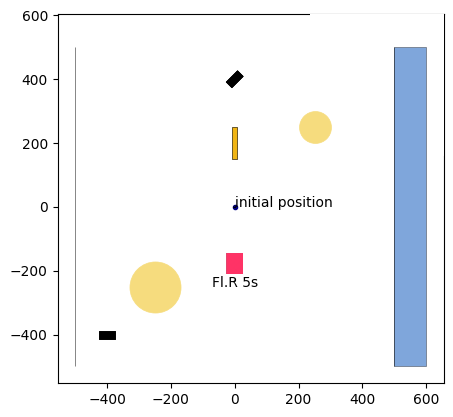

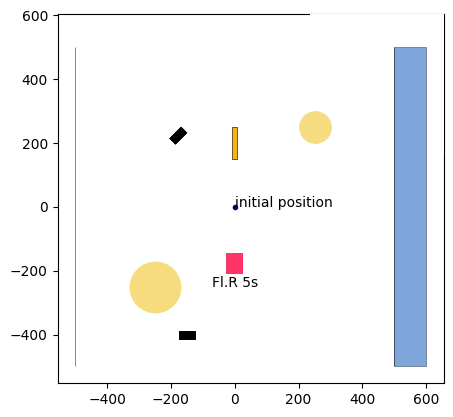

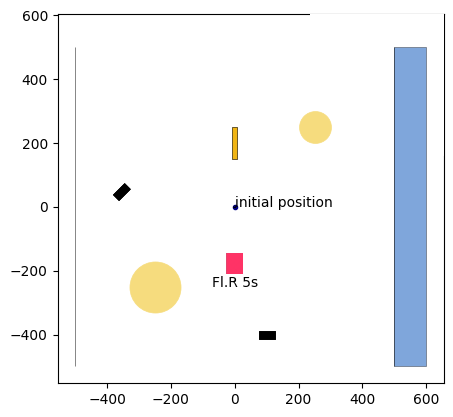

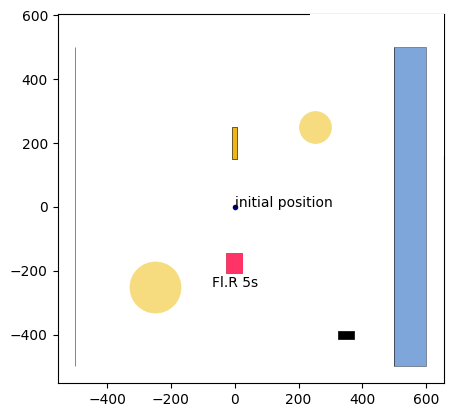

In [8]:
from commonocean.common.file_reader import CommonOceanFileReader
from commonocean.visualization.draw_dispatch_cr import draw_object
import matplotlib.pyplot as plt

scenario, planning_problem_set = CommonOceanFileReader(filename).open()

# Plotting Scenario in frames 0, 50, 100 and 150
frames = [0, 50, 100, 150]
for frame in frames:
    draw_object(scenario, draw_params={'time_begin': frame, 'trajectory_steps': 0})
    draw_object(planning_problem_set, draw_params={'time_begin': frame})
    plt.gca().set_aspect('equal')
    plt.show()